In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

os.makedirs("data", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

In [2]:
n = 10000  

departments = ["Emergency", "Internal Medicine", "Surgery", "Orthopedics", "Cardiology", "Neurology", "ICU"]
admission_types = ["Emergency", "Planned", "Transfer"]
genders = ["Female", "Male"]
insurance_types = ["National", "Private"]
nationalities = ["Finnish", "Greek", "Russian", "Ukrainian", "German", "Swedish", "Estonian", "Italian", "Spanish"]

diagnoses_by_dept = {
    "Emergency": ["Chest Pain", "Trauma", "Sepsis", "Shortness of Breath", "Stroke"],
    "Internal Medicine": ["Pneumonia", "Diabetes Complications", "COPD Exacerbation", "UTI", "Heart Failure"],
    "Surgery": ["Appendicitis", "Gallstones", "Hernia", "Post-op Infection", "Bowel Obstruction"],
    "Orthopedics": ["Fracture", "Hip Replacement", "Knee Injury", "Back Pain"],
    "Cardiology": ["Arrhythmia", "Heart Failure", "Myocardial Infarction", "Hypertension Crisis"],
    "Neurology": ["Stroke", "Seizure", "Migraine", "TIA"],
    "ICU": ["Sepsis", "Respiratory Failure", "Multi-organ Failure", "Post-op Complications"]}

first_names = ["John","Maria","Anna","George","Elena","Michael","Sofia","David","Nikos","Olivia","Daniel","Irina","Alex","Katerina","Mark","Laura"]
last_names  = ["Smith","Johnson","Brown","Wilson","Taylor","Anderson","Papadopoulos","Nikolaou","Ivanov","Petrov","Krasnov","Müller","Schmidt","Rossi","Garcia","Dubois"]

# Choose departments with realistic mix
dept = np.random.choice(departments, n, p=[0.26, 0.20, 0.16, 0.12, 0.10, 0.10, 0.06])

# Admission type depends on dept (Emergency more likely in ER/ICU)
admission_type = []
for d in dept:
    if d in ["Emergency", "ICU"]:
        admission_type.append(np.random.choice(admission_types, p=[0.85, 0.05, 0.10]))
    else:
        admission_type.append(np.random.choice(admission_types, p=[0.35, 0.55, 0.10]))
admission_type = np.array(admission_type)

# Age distribution: mostly adults
age = np.clip(np.random.normal(52, 18, n).round().astype(int), 0, 95)

gender = np.random.choice(genders, n, p=[0.52, 0.48])

insurance_type = np.random.choice(insurance_types, n, p=[0.72, 0.28])

nationality = np.random.choice(
    nationalities, n,
    p=[0.45, 0.15, 0.10, 0.08, 0.07, 0.05, 0.04, 0.03, 0.03])

# Dates: last 12 months
start = pd.Timestamp.today().normalize() - pd.Timedelta(days=365)
admission_dates = start + pd.to_timedelta(np.random.randint(0, 365, n), unit="D")

# Base LOS by department (days)
dept_los_mean = {
    "Emergency": 2.0, "Internal Medicine": 5.5, "Surgery": 4.5, "Orthopedics": 6.0,
    "Cardiology": 4.0, "Neurology": 5.0, "ICU": 9.0}

los = np.array([max(1, int(np.random.normal(dept_los_mean[d], 2.0))) for d in dept])
discharge_dates = admission_dates + pd.to_timedelta(los, unit="D")

# Diagnosis based on dept
diagnosis = np.array([np.random.choice(diagnoses_by_dept[d]) for d in dept])

# Readmission probability depends on dept + age + emergency
base_readmit = 0.12
readmit_prob = (
    base_readmit
    + (dept == "ICU") * 0.08
    + (dept == "Internal Medicine") * 0.05
    + (admission_type == "Emergency") * 0.03
    + (age >= 75) * 0.05)

readmit_prob = np.clip(readmit_prob, 0.02, 0.40)
readmitted_30_days = np.where(np.random.rand(n) < readmit_prob, "Yes", "No")

# Names + IDs
patient_id = np.arange(100001, 100001 + n)
first_name = np.random.choice(first_names, n)
last_name = np.random.choice(last_names, n)

bed_id = np.random.randint(1, 220, n)

df_raw = pd.DataFrame({
    "patient_id": patient_id,
    "first_name": first_name,
    "last_name": last_name,
    "nationality": nationality,
    "age": age,
    "gender": gender,
    "insurance_type": insurance_type,
    "admission_type": admission_type,
    "department": dept,
    "diagnosis": diagnosis,
    "bed_id": bed_id,
    "admission_date": admission_dates,
    "discharge_date": discharge_dates,
    "readmitted_30_days": readmitted_30_days})

df_raw["length_of_stay_days"] = (df_raw["discharge_date"] - df_raw["admission_date"]).dt.days

df_raw.to_csv("data/hospital_patients_raw.csv", index=False)
df_raw.head()


,patient_id,first_name,last_name,nationality,age,gender,insurance_type,admission_type,department,diagnosis,bed_id,admission_date,discharge_date,readmitted_30_days,length_of_stay_days
0,100001,Mark,Müller,Greek,38,Female,National,Planned,Internal Medicine,Pneumonia,209,2025-10-04,2025-10-10,No,6
1,100002,Daniel,Nikolaou,German,63,Female,Private,Emergency,ICU,Multi-organ Failure,97,2025-05-12,2025-05-15,No,3
2,100003,Maria,Smith,Finnish,76,Male,National,Emergency,Orthopedics,Hip Replacement,189,2025-09-10,2025-09-13,No,3
3,100004,Alex,Papadopoulos,Finnish,30,Female,National,Planned,Surgery,Hernia,44,2025-10-05,2025-10-13,No,8
4,100005,Elena,Brown,Finnish,83,Female,National,Emergency,Emergency,Shortness of Breath,1,2025-09-22,2025-09-23,No,1


In [3]:
df_dirty = df_raw.copy()

# 1) Missing values
for col, frac in [("insurance_type", 0.03), ("nationality", 0.02), ("diagnosis", 0.02)]:
    mask = np.random.rand(len(df_dirty)) < frac
    df_dirty.loc[mask, col] = np.nan

# 2) Inconsistent department labels (common in real data)
df_dirty.loc[df_dirty["department"] == "Internal Medicine", "department"] = np.where(
    np.random.rand(len(df_dirty[df_dirty["department"] == "Internal Medicine"])) < 0.25,
    "Internal med",
    "Internal Medicine")

# 3) Duplicate a small % of rows
dupe_count = int(0.01 * len(df_dirty))
df_dirty = pd.concat([df_dirty, df_dirty.sample(dupe_count, random_state=42)], ignore_index=True)

df_dirty.to_csv("data/hospital_patients_dirty.csv", index=False)
df_dirty.shape, df_dirty.head()


((10100, 15),
    patient_id first_name     last_name nationality  age  gender  \
 0      100001       Mark        Müller       Greek   38  Female   
 1      100002     Daniel      Nikolaou      German   63  Female   
 2      100003      Maria         Smith     Finnish   76    Male   
 3      100004       Alex  Papadopoulos     Finnish   30  Female   
 4      100005      Elena         Brown     Finnish   83  Female   
 
   insurance_type admission_type         department            diagnosis  \
 0       National        Planned  Internal Medicine            Pneumonia   
 1        Private      Emergency                ICU  Multi-organ Failure   
 2       National      Emergency        Orthopedics      Hip Replacement   
 3       National        Planned            Surgery               Hernia   
 4       National      Emergency          Emergency  Shortness of Breath   
 
    bed_id admission_date discharge_date readmitted_30_days  \
 0     209     2025-10-04     2025-10-10               

In [4]:
df = df_dirty.copy()

# Standardize department names
df["department"] = df["department"].replace({"Internal med": "Internal Medicine"})

# Handle missing values
df["insurance_type"] = df["insurance_type"].fillna("Unknown")
df["nationality"] = df["nationality"].fillna("Unknown")
df["diagnosis"] = df["diagnosis"].fillna("Unknown")

# Drop duplicates (by patient_id + admission_date is realistic)
df = df.drop_duplicates(subset=["patient_id", "admission_date"], keep="first").copy()

# Age groups
df["age_group"] = pd.cut(
    df["age"], bins=[0, 17, 39, 64, 79, 120],
    labels=["Child", "Young Adult", "Adult", "Senior", "Elderly"])

# Ensure LOS is valid
df["length_of_stay_days"] = df["length_of_stay_days"].clip(lower=1)

df.to_csv("data/hospital_patients_clean.csv", index=False)
df.shape, df.head()


((10000, 16),
    patient_id first_name     last_name nationality  age  gender  \
 0      100001       Mark        Müller       Greek   38  Female   
 1      100002     Daniel      Nikolaou      German   63  Female   
 2      100003      Maria         Smith     Finnish   76    Male   
 3      100004       Alex  Papadopoulos     Finnish   30  Female   
 4      100005      Elena         Brown     Finnish   83  Female   
 
   insurance_type admission_type         department            diagnosis  \
 0       National        Planned  Internal Medicine            Pneumonia   
 1        Private      Emergency                ICU  Multi-organ Failure   
 2       National      Emergency        Orthopedics      Hip Replacement   
 3       National        Planned            Surgery               Hernia   
 4       National      Emergency          Emergency  Shortness of Breath   
 
    bed_id admission_date discharge_date readmitted_30_days  \
 0     209     2025-10-04     2025-10-10               

In [5]:
total_admissions = len(df)
unique_patients = df["patient_id"].nunique()
avg_los = df["length_of_stay_days"].mean()
readmit_rate = (df["readmitted_30_days"] == "Yes").mean()
pct_private = (df["insurance_type"] == "Private").mean()

kpis = pd.DataFrame({
    "KPI": ["Total Admissions", "Unique Patients", "Avg Length of Stay (days)", "30-Day Readmission Rate", "Private Insurance Share"],
    "Value": [total_admissions, unique_patients, round(avg_los, 2), round(readmit_rate * 100, 2), round(pct_private * 100, 2)]})

kpis


,KPI,Value
0,Total Admissions,10000.00
1,Unique Patients,10000.00
2,Avg Length of Stay (days),4.14
3,30-Day Readmission Rate,15.54
4,Private Insurance Share,26.96


In [6]:
kpis.to_csv("outputs/kpis_summary.csv", index=False)


In [7]:
dept_perf = (df.groupby("department")
             .agg(admissions=("patient_id","count"),
                  avg_los=("length_of_stay_days","mean"),
                  readmit_rate=("readmitted_30_days", lambda x: (x=="Yes").mean()))
             .reset_index())

dept_perf["avg_los"] = dept_perf["avg_los"].round(2)
dept_perf["readmit_rate"] = (dept_perf["readmit_rate"] * 100).round(2)

dept_perf.sort_values("admissions", ascending=False)


,department,admissions,avg_los,readmit_rate
1,Emergency,2656,1.99,14.19
3,Internal Medicine,2034,5.01,20.26
6,Surgery,1613,4.07,13.64
5,Orthopedics,1197,5.53,14.20
0,Cardiology,962,3.55,13.62
4,Neurology,949,4.50,11.70
2,ICU,589,8.64,22.58


In [8]:
dept_perf.to_csv("outputs/department_performance.csv", index=False)


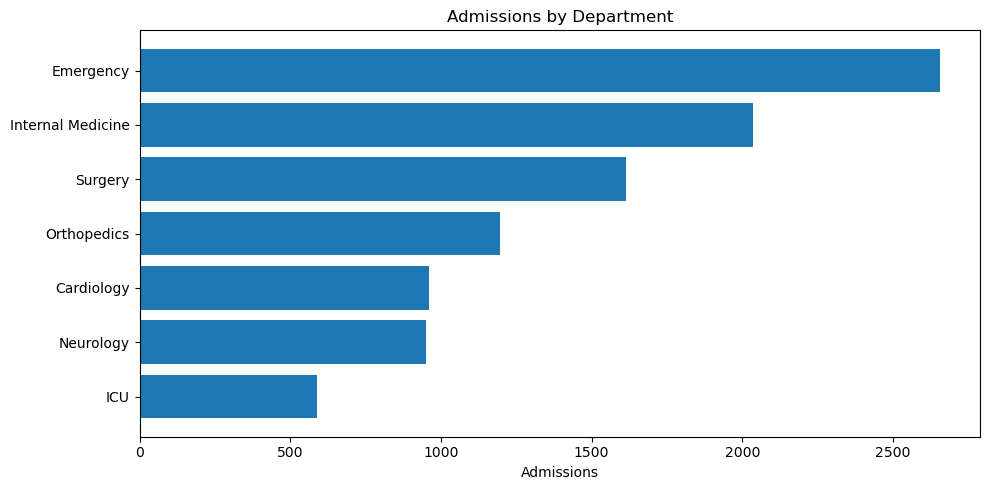

In [9]:
plot_df = dept_perf.sort_values("admissions", ascending=True)

plt.figure(figsize=(10,5))
plt.barh(plot_df["department"], plot_df["admissions"])
plt.title("Admissions by Department")
plt.xlabel("Admissions")
plt.tight_layout()
plt.savefig("outputs/admissions_by_department.png", dpi=200)

plt.show()


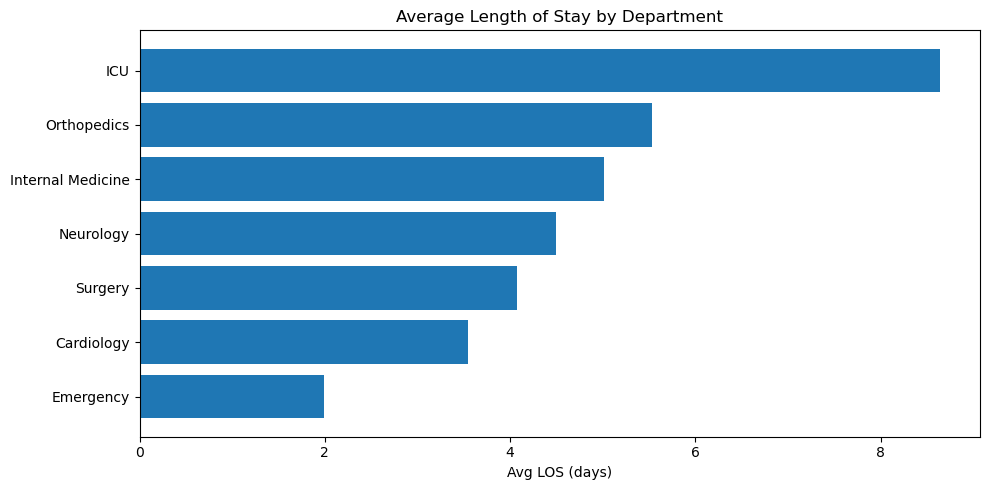

In [10]:
plot_df = dept_perf.sort_values("avg_los", ascending=True)

plt.figure(figsize=(10,5))
plt.barh(plot_df["department"], plot_df["avg_los"])
plt.title("Average Length of Stay by Department")
plt.xlabel("Avg LOS (days)")
plt.tight_layout()
plt.savefig("outputs/avg_los_by_department.png", dpi=200)

plt.show()


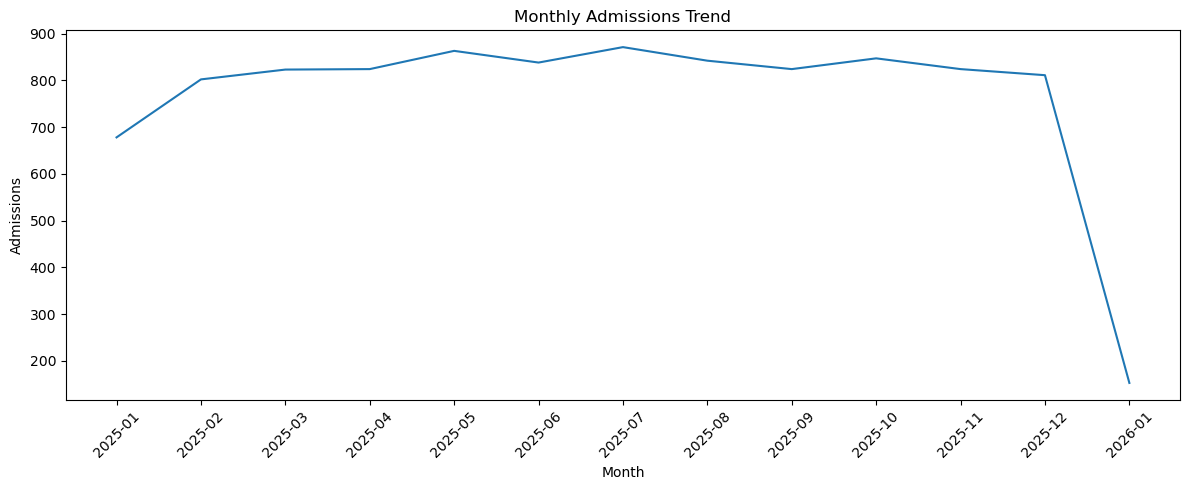

In [11]:
df["month"] = df["admission_date"].dt.to_period("M").astype(str)
monthly = df.groupby("month").size().reset_index(name="admissions")

plt.figure(figsize=(12,5))
plt.plot(monthly["month"], monthly["admissions"])
plt.title("Monthly Admissions Trend")
plt.xlabel("Month")
plt.ylabel("Admissions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/monthly_admissions_trend.png", dpi=200)

plt.show()


In [12]:
import os

# Make sure folders exist
os.makedirs("data", exist_ok=True)

# Create a SQL-friendly copy (no spaces in column names, consistent types)
sql_df = df.copy()

# Standardize date columns
sql_df["admission_date"] = pd.to_datetime(sql_df["admission_date"])
sql_df["discharge_date"] = pd.to_datetime(sql_df["discharge_date"])

# Add helpful time columns
sql_df["admission_month"] = sql_df["admission_date"].dt.to_period("M").astype(str)
sql_df["admission_year"] = sql_df["admission_date"].dt.year

# Save a clean CSV for SQL work
sql_df.to_csv("data/hospital_patients_clean.csv", index=False)

sql_df.head()


,patient_id,first_name,last_name,nationality,age,gender,insurance_type,admission_type,department,diagnosis,bed_id,admission_date,discharge_date,readmitted_30_days,length_of_stay_days,age_group,month,admission_month,admission_year
0,100001,Mark,Müller,Greek,38,Female,National,Planned,Internal Medicine,Pneumonia,209,2025-10-04,2025-10-10,No,6,Young Adult,2025-10,2025-10,2025
1,100002,Daniel,Nikolaou,German,63,Female,Private,Emergency,ICU,Multi-organ Failure,97,2025-05-12,2025-05-15,No,3,Adult,2025-05,2025-05,2025
2,100003,Maria,Smith,Finnish,76,Male,National,Emergency,Orthopedics,Hip Replacement,189,2025-09-10,2025-09-13,No,3,Senior,2025-09,2025-09,2025
3,100004,Alex,Papadopoulos,Finnish,30,Female,National,Planned,Surgery,Hernia,44,2025-10-05,2025-10-13,No,8,Young Adult,2025-10,2025-10,2025
4,100005,Elena,Brown,Finnish,83,Female,National,Emergency,Emergency,Shortness of Breath,1,2025-09-22,2025-09-23,No,1,Elderly,2025-09,2025-09,2025


In [13]:
import sqlite3
import os

os.makedirs("data", exist_ok=True)

conn = sqlite3.connect("data/hospital.db")
sql_df.to_sql("hospital_patients", conn, if_exists="replace", index=False)
conn.close()

print("✅ SQLite DB created: data/hospital.db")


✅ SQLite DB created: data/hospital.db


In [14]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/hospital.db")

pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,hospital_patients


In [15]:
pd.read_sql("PRAGMA table_info(hospital_patients);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,patient_id,INTEGER,0,None,0
1,1,first_name,TEXT,0,None,0
2,2,last_name,TEXT,0,None,0
3,3,nationality,TEXT,0,None,0
4,4,age,INTEGER,0,None,0
5,5,gender,TEXT,0,None,0
6,6,insurance_type,TEXT,0,None,0
7,7,admission_type,TEXT,0,None,0
8,8,department,TEXT,0,None,0
9,9,diagnosis,TEXT,0,None,0


In [16]:
query = """
SELECT
  department,
  COUNT(*) AS admissions,
  ROUND(AVG(length_of_stay_days), 2) AS avg_los
FROM hospital_patients
GROUP BY department
ORDER BY admissions DESC;
"""
dept_df = pd.read_sql(query, conn)
dept_df


,department,admissions,avg_los
0,Emergency,2656,1.99
1,Internal Medicine,2034,5.01
2,Surgery,1613,4.07
3,Orthopedics,1197,5.53
4,Cardiology,962,3.55
5,Neurology,949,4.50
6,ICU,589,8.64
